In [53]:
import pandas as pd
import numpy as np
import warnings
import scorecardpy as sc
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import utils
from sklearn.preprocessing import StandardScaler
import scorecardpy as sc
import re
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score


application = pd.read_csv('/Users/will/Documents/GitHub/consumer-credit-risk/coursework2_application_sampled.csv')
performance = pd.read_csv('/Users/will/Documents/GitHub/consumer-credit-risk/coursework2_performance_data_sampled.csv')

# merge the data from the two csvs
data_full = performance.merge(application, on='LOAN SEQUENCE NUMBER', how='left')

# change monthly reoprting period to datetime
data_full['MONTHLY REPORTING PERIOD'] = pd.to_datetime(data_full['MONTHLY REPORTING PERIOD'], format='%Y%m')

# if column value is RA then it is 3
data_full['CURRENT LOAN DELINQUENCY STATUS'] = data_full['CURRENT LOAN DELINQUENCY STATUS'].apply(lambda x: 3 if x == 'RA' else x)

# change to int
data_full['CURRENT LOAN DELINQUENCY STATUS'] = data_full['CURRENT LOAN DELINQUENCY STATUS'].astype(int)
# change the column CURRENT LOAN DELINQUENCY STATUS
# slide 13 4 intro to analytics
# if value is less then 3 then it is 0 # else it is 1 # zero represents no default # one represents default
data_full['DEFAULT'] = data_full['CURRENT LOAN DELINQUENCY STATUS'].apply(lambda x: 0 if x < 3 else 1)

# drop columns
data_full.drop(columns=['SELLER NAME', 'SERVICER NAME','DEFECT SETTLEMENT DATE', 'ZERO BALANCE EFFECTIVE DATE','DUE DATE OF LAST PAID INSTALLMENT (DDLPI)',
 'MI RECOVERIES', 'NET SALE PROCEEDS', 'NON MI RECOVERIES', 'TOTAL EXPENSES', 'LEGAL COSTS', 'MAINTENANCE AND PRESERVATION COSTS', 'TAXES AND INSURANCE', 'MISCELLANEOUS EXPENSES', 'ACTUAL LOSS CALCULATION',
 'POSTAL CODE', 'ZERO BALANCE REMOVAL UPB', 'PRE-RELIEF REFINANCE LOAN SEQUENCE NUMBER', 'METROPOLITAN STATISTICAL AREA (MSA) OR METROPOLITAN DIVISION',
 'FIRST PAYMENT DATE', 'MATURITY DATE'], inplace=True)

########### data cleaning ###########
# if zero balance code is 1 then remove the row
data_full = data_full[~(data_full['ZERO BALANCE CODE'] == 1)]

# remove the rows where CURRENT ACTUAL UPB is 0
data_full = data_full[~(data_full['CURRENT ACTUAL UPB'] == 0)]

data_full['CUMULATIVE MODIFICATION COST'].fillna(0, inplace=True)
data_full['DELINQUENT ACCRUED INTEREST'].fillna(0, inplace=True)
data_full['CURRENT MONTH MODIFICATION COST'].fillna(0, inplace=True)

# change these columns to category 
data_full['CURRENT LOAN DELINQUENCY STATUS'] = data_full['CURRENT LOAN DELINQUENCY STATUS'].astype('category')
data_full['ZERO BALANCE CODE'] = data_full['ZERO BALANCE CODE'].astype('category')
data_full['PROPERTY VALUATION METHOD'] = data_full['PROPERTY VALUATION METHOD'].astype('category')

# Replace specific missing values with 'np.nan'
missing_value_map = {
    'CREDIT SCORE': [9999],
    'FIRST TIME HOMEBUYER FLAG': [9],
    'MI PERCENT': [999],
    'NUMBER OF UNITS': [99],
    'OCCUPANCY STATUS': [9],
    'ORIGINAL CLTV': [999],
    'ORIGINAL DTI RATIO': [999],
    'ORIGINAL LTV': [999],
    'CHANNEL': [9],
    'PROPERTY TYPE': [99],
    'LOAN PURPOSE': [9],
    'NUMBER OF BORROWERS': [99],
    'PROGRAM INDICATOR': [9],
    'PROPERTY VALUATION METHOD': [9],
    'MI CANCELLATION INDICATOR': [9, 7]
}

for column, values in missing_value_map.items():
    if column in data_full.columns:
        data_full[column] = data_full[column].replace(values, np.nan)

###### feature engineering ########

# add boolean for whether loan in delinquency or not 
data_full['DELINQUENCY'] = data_full['CURRENT LOAN DELINQUENCY STATUS'].apply(lambda x : 1 if x != 0 else 0)

# cum sum of the delinquency status
data_full['DEFAULT CUM SUM'] = data_full.groupby('LOAN SEQUENCE NUMBER')['DEFAULT'].cumsum()

# last month current loan deliquency status
data_full['LAST MONTH DELINQUENCY STATUS'] = data_full.groupby('LOAN SEQUENCE NUMBER')['CURRENT LOAN DELINQUENCY STATUS'].shift(1).fillna(0).astype(int)

# rolling 12 months time in deliquency
data_full['MONTHS IN DELINQUENCY PAST 12'] = data_full.groupby('LOAN SEQUENCE NUMBER')['DELINQUENCY'].rolling(12, min_periods=1).sum().reset_index(drop=True)

# make a function that takes in a pd.series of zeroes and ones and then returns a new series with every 12 before the ones being ones as well
def default_next_12(default_vector):
     
    if np.where(default_vector==1)[0].size==0:
        return default_vector
     
    first_default = np.where(default_vector==1)[0][0]
    defualt_next_12_vector = np.zeros(len(default_vector))
    defualt_next_12_vector[max(0,first_default-12):] = 1

    return(defualt_next_12_vector)

default_next_12_col = []

# group the data by LOAN SEQUENCE NUMBER
for _, group in data_full.groupby('LOAN SEQUENCE NUMBER'):
    default_next_12_series = default_next_12(group['DEFAULT'])

    default_next_12_col.extend(default_next_12_series)

data_full['DEFAULT_NEXT_12'] = [x == 1 for x in default_next_12_col]

# remove rows where the cumsum != 0
data_full = data_full[data_full['DEFAULT CUM SUM'] == 0]

# turn into dummy variables
data_full = pd.get_dummies(data_full, columns=['MODIFICATION FLAG', 'ZERO BALANCE CODE', 
                                               'STEP MODIFICATION FLAG', 'PAYMENT DEFERRAL', 'DELINQUENCY DUE TO DISASTER', 
                                               'BORROWER ASSISTANCE STATUS CODE', 'FIRST TIME HOMEBUYER FLAG', 'OCCUPANCY STATUS', 
                                               'CHANNEL', 'PREPAYMENT PENALTY MORTGAGE (PPM) FLAG', 'AMORTIZATION TYPE', 'PROPERTY STATE', 
                                               'PROPERTY TYPE', 'LOAN PURPOSE', 'SUPER CONFORMING FLAG', 
                                               'PROGRAM INDICATOR', 'RELIEF REFINANCE INDICATOR', 'INTEREST ONLY INDICATOR (I/O INDICATOR)', 
                                               'MI CANCELLATION INDICATOR', 'PROPERTY VALUATION METHOD'], drop_first=True, dummy_na=True)

# drop credit score nulls only 40ish obs
data_full = data_full[~(data_full['CREDIT SCORE'].isnull())]

# drop DEFAULT column
data_full.drop(columns=['DEFAULT','DEFAULT CUM SUM'], inplace=True)

############# train test oot split ################

# the date for this is different than Q1 we make PD for every month not in oot
# make data 
data_full_train = data_full[data_full['MONTHLY REPORTING PERIOD'] < '2024-06-01']

# make out of time data
data_full_oot = data_full[data_full['MONTHLY REPORTING PERIOD'] == '2024-06-01']

# Split the data into features and target
X = data_full_train.drop(columns=['DEFAULT_NEXT_12'])
y = data_full_train['DEFAULT_NEXT_12']

# do split test train but do it by the LOAN SEQUENCE NUMBER
X_train, X_test, y_train, y_test = utils.train_test_split_by_group(X, y, 'LOAN SEQUENCE NUMBER', test_size=0.5,  random_state=42)

# save the loan sequence numbers to use later
x_train_loan_seq = X_train['LOAN SEQUENCE NUMBER']
x_test_loan_seq = X_test['LOAN SEQUENCE NUMBER']

# save the monthly reporting period to use later
x_train_monthly_reporting_period = X_train['MONTHLY REPORTING PERIOD']
x_test_monthly_reporting_period = X_test['MONTHLY REPORTING PERIOD']

# remove the LOAN SEQUENCE NUMBER from the train and test data
X_train.drop(columns=['LOAN SEQUENCE NUMBER','MONTHLY REPORTING PERIOD'], inplace=True)
X_test.drop(columns=['LOAN SEQUENCE NUMBER', 'MONTHLY REPORTING PERIOD'], inplace=True)

# combine the train and test data
X_train['DEFAULT_NEXT_12'] = y_train
X_test['DEFAULT_NEXT_12'] = y_test

In [54]:
# get ordered and unordered variables
X_train_ordered, X_train_unordered = utils.split_dataframe_by_columns(X_train)
X_test_ordered, X_test_unordered = utils.split_dataframe_by_columns(X_test)
oot_ordered, oot_unordered = utils.split_dataframe_by_columns(data_full_oot)

# combine the train and test data
X_train_ordered['DEFAULT_NEXT_12'] = y_train.astype(int)
X_test_ordered['DEFAULT_NEXT_12'] = y_test

import pickle
# import pkl files
with open('model.pkl', 'rb') as f:
    model_dict = pickle.load(f)
bins_adj = model_dict['bins_adj']
model = model_dict['model']

train_woe = sc.woebin_ply(X_train_ordered, bins_adj) # Calculate WoE dataset (train)
test_woe = sc.woebin_ply(X_test_ordered, bins_adj) # Calculate WoE dataset (test)


######### add unordered variables back to the train and test set #########
X_train_model = pd.concat([train_woe, X_train_unordered], axis=1)
X_test_model = pd.concat([test_woe, X_test_unordered], axis=1)

X_train_model = X_train_model.drop(columns=['DEFAULT_NEXT_12']).fillna(0)
y_train_model = train_woe['DEFAULT_NEXT_12']

X_test_model = X_test_model.drop(columns=['DEFAULT_NEXT_12']).fillna(0)
y_test_model = test_woe['DEFAULT_NEXT_12']

# reoder the columns for each dataset
X_train_model = X_train_model[model.feature_names_in_]
X_test_model = X_test_model[model.feature_names_in_]

# get AUC on train set
y_train_pred = model.predict_proba(X_train_model)[:,1]
auc_train = roc_auc_score(y_train_model, y_train_pred)
print(f" AUC on train set: {auc_train:.4f}")

# get auc on test set
y_test_pred = model.predict_proba(X_test_model)[:, 1]
auc_test = roc_auc_score(y_test_model, y_test_pred)
print(f" AUC on test set: {auc_test:.4f}")

[INFO] converting into woe values ...
Woe transformating on 814594 rows and 20 columns in 00:00:31
[INFO] converting into woe values ...
Woe transformating on 815032 rows and 20 columns in 00:00:33
 AUC on train set: 0.8568
 AUC on test set: 0.8587


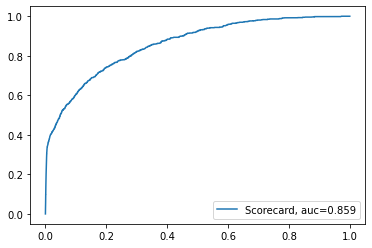

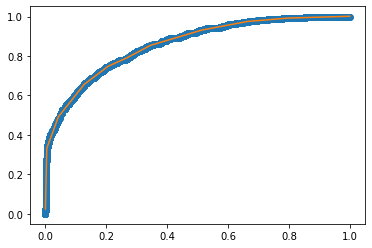

In [55]:
# create auc curve for the logistic regression model 
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_model, y_test_pred)

# Correct the infinite threshold
thresholds[0] = 1

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = y_test_model,
                             y_score = y_test_pred),
               decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="Scorecard, auc="+str(auc))
plt.legend(loc=4)
plt.show()

import pwlf
# Define the curve with the ROC curve
piecewise_AUC = pwlf.PiecewiseLinFit(fpr, tpr)

# Calculate the best curve. Long!
nr_cuts = 10
res = piecewise_AUC.fitfast(nr_cuts, pop=2)

ROC_curve = pd.DataFrame({'fpr': fpr, 'threshold': thresholds})
ROC_curve

# Apply cuts!
cuts = piecewise_AUC.fit_with_breaks(res)

# predict for the determined points
xHat = np.linspace(min(fpr), max(fpr), num=10000)
yHat = piecewise_AUC.predict(xHat)

# plot the results
plt.figure()
plt.plot(fpr, tpr, 'o')
plt.plot(xHat, yHat, '-')
plt.show()

In [ ]:
PDs_Tab = pd.crosstab(pd_cut,
                      loans['Default'],
                      normalize = False)

# Add a new column for the true rate
PDs_Tab['Default Rate'] = PDs_Tab[True] / (PDs_Tab[True] + PDs_Tab[False])


In [56]:
# Find probability associated with every cut
pbb_cuts = np.zeros_like(res)
i = 0

for fpr in res:
  # Get how far the fpr is from each ROC curve fpr point.
  temp = np.abs(np.round(ROC_curve.fpr, 2) - np.round(fpr, 2))

  # Get the index of the smallest value
  idx = np.argmin(temp)

  # Get the threshold associated with that point
  pbb_cuts[i] = ROC_curve.threshold[idx]
  i += 1

# Reverse to correctly sort
pbb_cuts = np.flip(pbb_cuts)
pbb_cuts

# Add 0 (and one) if not present. 1 is found, so we don't need to adjust it.
pbb_cuts = np.insert(pbb_cuts, 0, 0)

# Get unique values
pbb_cuts = np.unique(pbb_cuts)

# Display the result
pbb_cuts

pd_cut = pd.cut(y_test_pred, pbb_cuts)
pd_cut

# Add the PDCut variable to our dataframe
PD_cut = pd.Series('PD_Cut', pd.cut(y_test_pred, pbb_cuts).astype(str))

loans = pd.DataFrame({'Default' : y_test_model, 'Portfolio' : x_test_loan_seq, 'PD_cut' : PD_cut.index, 'Probs': y_test_pred, 'Period': x_test_monthly_reporting_period})

# Create pivot table
PD_monthly = pd.pivot_table(loans,
                            values = 'Default',
                            index = 'Period',
                            columns = 'PD_cut',
                            aggfunc = 'mean'
                            )

PD_monthly

PD_cut,"(0.0, 0.108]","(0.108, 0.229]","(0.229, 0.277]","(0.277, 0.338]","(0.338, 0.414]","(0.414, 0.456]","(0.456, 0.487]","(0.487, 0.546]","(0.546, 0.66]","(0.66, 1.0]"
Period,,,,,,,,,,
2021-01-01,0.0,0.001045,0.005348,0.003103,0.004778,0.012706,0.012791,0.008006,0.027778,0.155902
2021-02-01,0.0,0.000649,0.004024,0.002157,0.005056,0.010526,0.012941,0.006682,0.023270,0.143498
2021-03-01,0.0,0.000303,0.003436,0.002111,0.005708,0.009752,0.010638,0.009112,0.025246,0.130170
2021-04-01,0.0,0.000563,0.003266,0.002414,0.005207,0.011278,0.010601,0.010000,0.023765,0.120466
2021-05-01,0.0,0.000816,0.002262,0.002362,0.005123,0.011136,0.011806,0.010878,0.020992,0.114625
2021-06-01,0.0,0.000797,0.001319,0.003085,0.006454,0.008070,0.010539,0.009992,0.024756,0.110169
2021-07-01,0.0,0.000774,0.001264,0.003391,0.007309,0.009475,0.010441,0.012140,0.020275,0.111929
2021-08-01,0.0,0.000762,0.001225,0.003317,0.007145,0.009386,0.010227,0.011161,0.022876,0.113602
2021-09-01,0.0,0.000745,0.001202,0.004337,0.007281,0.009332,0.012629,0.013960,0.024422,0.117737


## Economic Factors

In [90]:
# import df 
# Load the CSV file
fred_df = pd.read_csv('FRED-2024-07.csv')

# Drop the first row
fred_df = fred_df.iloc[1:]

# Convert 'sasdate' column to datetime
fred_df['sasdate'] = pd.to_datetime(fred_df['sasdate'])

# Filter rows between 2021-06-01 and 2024-06-01 (inclusive)
filtered_df = fred_df[
    (fred_df['sasdate'] >= '2021-01-01') & 
    (fred_df['sasdate'] <= '2024-05-01')
]
filtered_df.drop(columns=['sasdate'], inplace=True)

# standardize economic factors
scaler = StandardScaler()
# Select the columns to standardize
columns_to_standardize = ['CPIAUCSL', 'REALLN', 'HOUST', 'UNRATE', 'DPCERA3M086SBEA',
                          'RPI', 'RETAILx', 'INDPRO', 'IPB51222S', 
                    'UNRATE', 'PAYEMS', 'HOUST', 'REALLN', 'CPIAUCSL']
# Standardize the selected columns
filtered_df[columns_to_standardize] = scaler.fit_transform(filtered_df[columns_to_standardize])

# Optional: Reset index
filtered_df = filtered_df.reset_index(drop=True)

# Filter DataFrame to keep only the selected columns
econ_factors = filtered_df[columns_to_standardize]

In [91]:
len(econ_factors)

41

In [92]:
len(PD_monthly)

41

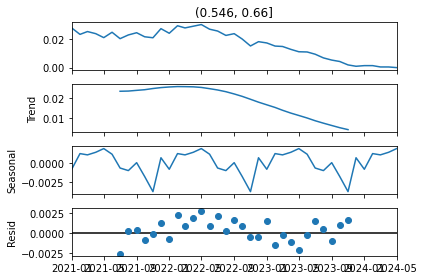

In [93]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

decomposition = seasonal_decompose(PD_monthly.iloc[:, 8], model='additive')
fig = decomposition.plot()
plt.show()

In [ ]:
# Define the search space.
p = range(1, 6)
d = range(0, 2)
q = range(0, 2)

# Create an interative list of ps, ds, qs.
from itertools import product
pdq = list(product(p, d, q))

# Seasonal parameters. One year back.
ps = range(0, 4)
ds = range(0, 1)
qs = range(0, 1)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(product(ps, ds, qs))]

# Train the models for a series and test multiple values.
y = PD_monthly.iloc[:, 4] # Choose the fifth rating

aic_out = []

for param in pdq:
  for param_seasonal in seasonal_pdq:
      mod = SARIMAX(y,
                    exog=np.asarray(econ_factors),
                    order=param,
                    seasonal_order=param_seasonal,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                    )
      results = mod.fit(verbose=False)
      aic_out.append([param, param_seasonal, results.aic])
      print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

# Nicer formatting
aic_out = pd.DataFrame(aic_out,
                       columns = ['(p,q,r)', '(ps, qs, rs, S)', 'AIC'])

In [95]:
aic_out.sort_values(by='AIC', ascending=True)

,"(p,q,r)","(ps, qs, rs, S)",AIC
0,"(1, 0, 0)","(0, 0, 0, 12)",-467.734242
4,"(1, 0, 1)","(0, 0, 0, 12)",-457.862144
20,"(2, 0, 1)","(0, 0, 0, 12)",-455.300127
16,"(2, 0, 0)","(0, 0, 0, 12)",-454.399161
8,"(1, 1, 0)","(0, 0, 0, 12)",-453.643443
...,...,...,...
63,"(4, 1, 1)","(3, 0, 0, 12)",46.000000
75,"(5, 1, 0)","(3, 0, 0, 12)",46.000000
67,"(5, 0, 0)","(3, 0, 0, 12)",46.000000
71,"(5, 0, 1)","(3, 0, 0, 12)",48.000000


In [96]:
significant_factors = econ_factors.iloc[:, [1, 11]]

mod_BB = SARIMAX(y,
              exog=np.asarray(econ_factors),
              order=(1,0,0),
              seasonal_order=(0,0,0,12),
              enforce_stationarity=False,
              enforce_invertibility=False)
results_BB = mod_BB.fit(maxiter=100000)

print(results_BB.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84838D+00    |proj g|=  2.97137D+02

At iterate    5    f= -5.99515D+00    |proj g|=  9.25089D+01

At iterate   10    f= -6.02282D+00    |proj g|=  6.02439D+01

At iterate   15    f= -6.03943D+00    |proj g|=  7.81700D+01

At iterate   20    f= -6.05159D+00    |proj g|=  4.71991D+01

At iterate   25    f= -6.07371D+00    |proj g|=  2.00332D+01

At iterate   30    f= -6.08385D+00    |proj g|=  4.40402D+01

At iterate   35    f= -6.09048D+00    |proj g|=  3.62587D+01

At iterate   40    f= -6.09387D+00    |proj g|=  7.87395D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0005      0.001      0.539      0.590      -0.001       0.002
x2            -0.0015      0.001     -1.317      0.188      -0.004       0.001
x3             0.0001   5.91e-05      1.751      0.080   -1.24e-05       0.000
x4         -1.217e-06      0.000     -0.004      0.996      -0.001       0.001
x5             0.0007      0.001      0.818      0.413      -0.001       0.002
x6          7.134e-05      0.000      0.280      0.779      -0.000       0.001
x7            -0.0006      0.001     -0.617      0.537      -0.002       0.001
x8            -0.0005      0.001     -0.903      0.367      -0.002       0.001
x9         -7.608e-05      0.000     -0.734      0.463      -0.000       0.000
x10        -1.217e-06      0.000     -0.004      0.996      -0.001       0.001
x11            0.0012      0.003      0.404      0.6